In [56]:
# The output here might be different from what's shown in the report because I restarted the kernel and ran it again.

In [1]:
# Load the images

from huggingface_hub import snapshot_download
from datasets import load_dataset
from huggingface_hub import login

local_dir = snapshot_download(repo_id="akridge/NOAA-ESD-CORAL-Bleaching-Dataset", repo_type="dataset")
dataset = load_dataset("imagefolder", data_dir=local_dir)
dataset

Fetching 10422 files:   0%|          | 0/10422 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7292 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1562 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1565 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7292
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1562
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1565
    })
})

In [2]:
# Prepare the training set

x_train = []
y_train = []

for i in range(7292):
    x_train.append(dataset["train"][i]["image"])
    y_train.append(dataset["train"][i]["label"])

In [3]:
# Prepare the validation set

x_valid = []
y_valid = []

for i in range(1562):
    x_valid.append(dataset["validation"][i]["image"])
    y_valid.append(dataset["validation"][i]["label"])

In [4]:
# Apply clahe to the training set

import cv2
import numpy as np
import matplotlib.pyplot as plt


new_x_train = []

def apply_clahe(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    result = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

for image in x_train:
    image = np.array(image)
    the_image = apply_clahe(image)
    new_x_train.append(the_image)



In [5]:
# Apply clahe to the validation set

new_x_valid = []

def apply_clahe(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    result = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

for image in x_valid:
    image = np.array(image)
    the_image = apply_clahe(image)
    new_x_valid.append(the_image)

In [6]:
# Split images, apply NDBI, and recombine them (training set)

import numpy as np

whole_image_list = []

for image in new_x_train:
    image = np.array(image)
    h, w, _ = image.shape
    mid_h, mid_w = h // 2, w // 2
    top_left = image[0:mid_h, 0:mid_w]
    top_right = image[0:mid_h, mid_w:w]
    bottom_left = image[mid_h:h, 0:mid_w]
    bottom_right = image[mid_h:h, mid_w:w]
    whole_image = [top_left, top_right, bottom_left, bottom_right]
    whole_image_list.append(whole_image)



NDBI_list = []
whole_NDBI_list = []

for image in whole_image_list:
    NDBI_list = []
    for quadrant in image:
        quadrant = quadrant / 255.0
        Red = quadrant[:,:,0]
        Green = quadrant[:,:,1]
        Blue = quadrant[:,:,2]
        NDBI = (Red - Blue) / (Red + Blue + 1e-6)
        NDBI = np.clip(NDBI, -1, 1)
        NDBI_list.append(NDBI)
    whole_NDBI_list.append(NDBI_list)



recombined_images = []
i = 0

for result in whole_NDBI_list:
    top_left = result[0]
    top_right = result[1]
    bottom_left = result[2]
    bottom_right = result[3]
    top = np.hstack((top_left, top_right))
    bottom = np.hstack((bottom_left, bottom_right))
    merged_image = np.vstack((top, bottom))
    recombined_images.append(merged_image)


In [7]:
# Split images, apply NDBI, and recombine them (validation set)

import numpy as np

whole_image_list_valid = []

for image in new_x_valid:
    image = np.array(image)
    h, w, _ = image.shape
    mid_h, mid_w = h // 2, w // 2
    top_left = image[0:mid_h, 0:mid_w]
    top_right = image[0:mid_h, mid_w:w]
    bottom_left = image[mid_h:h, 0:mid_w]
    bottom_right = image[mid_h:h, mid_w:w]
    whole_image = [top_left, top_right, bottom_left, bottom_right]
    whole_image_list_valid.append(whole_image)


NDBI_list_valid = []
whole_NDBI_list_valid = []

for image in whole_image_list_valid:
    NDBI_list_valid = []
    for quadrant in image:
        quadrant = quadrant / 255.0
        Red = quadrant[:,:,0]
        Green = quadrant[:,:,1]
        Blue = quadrant[:,:,2]
        NDBI = (Red - Blue) / (Red + Blue + 1e-6)
        NDBI = np.clip(NDBI, -1, 1)
        NDBI_list_valid.append(NDBI)
    whole_NDBI_list_valid.append(NDBI_list_valid)


recombined_images_valid = []
i = 0

for result in whole_NDBI_list_valid:
    top_left = result[0]
    top_right = result[1]
    bottom_left = result[2]
    bottom_right = result[3]
    top = np.hstack((top_left, top_right))
    bottom = np.hstack((bottom_left, bottom_right))
    merged_image = np.vstack((top, bottom))
    recombined_images_valid.append(merged_image)

In [8]:
# Apply KMeans clustering to the training set

from sklearn.cluster import KMeans

KMeans_label_list = []

for image in recombined_images:
    image_flat = image.reshape((-1, 1))
    kmeans = KMeans(n_clusters=6, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(image_flat)
    labels = labels.reshape(image.shape)
    # Instead of normalizing labels, map back to cluster centers
    cluster_centers = kmeans.cluster_centers_.flatten()
    clustered_img = np.take(cluster_centers, labels)
    # Normalize clustered image
    clustered_img = clustered_img - np.min(clustered_img)
    clustered_img = clustered_img / (np.max(clustered_img) + 1e-7)
    KMeans_label_list.append(clustered_img)

In [9]:
# Apply KMeans clustering to the validation set

from sklearn.cluster import KMeans

KMeans_label_list_valid = []

for image in recombined_images_valid:
    image_flat = image.reshape((-1, 1))
    kmeans = KMeans(n_clusters=6, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(image_flat)
    labels = labels.reshape(image.shape)
    cluster_centers = kmeans.cluster_centers_.flatten()
    clustered_img = np.take(cluster_centers, labels)
    clustered_img = clustered_img - np.min(clustered_img)
    clustered_img = clustered_img / (np.max(clustered_img) + 1e-7)
    KMeans_label_list_valid.append(clustered_img)

In [10]:
# Apply Gaussian Blur to both training and validation sets (for smoothing)

import cv2
KMeans_label_list = [cv2.GaussianBlur(img, (5, 5), 0.5) for img in KMeans_label_list]
KMeans_label_list_valid = [cv2.GaussianBlur(img, (5, 5), 0.5) for img in KMeans_label_list_valid]

In [11]:
# Concatenate recombined images and KMeans label arrays (training set)

recombined_images_orig = np.expand_dims(recombined_images, axis=-1)

recombined_images_kmeans = np.expand_dims(KMeans_label_list, axis=-1)

recombined_images_orig = recombined_images_orig.astype('float32')

recombined_images_orig = (recombined_images_orig + 1) / 2.0

recombined_images_kmeans = recombined_images_kmeans.astype('float32')

combined_input = np.concatenate([recombined_images_orig, recombined_images_kmeans], axis=-1)

labels_train = np.array(y_train).astype('float32')
labels_valid = np.array(y_valid).astype('float32')


(7292, 224, 224, 2)


In [12]:
# Concatenate recombined images and KMeans label arrays (validation set)

recombined_images_orig_valid = np.expand_dims(recombined_images_valid, axis=-1)

recombined_images_kmeans_valid = np.expand_dims(KMeans_label_list_valid, axis=-1)

recombined_images_orig_valid = recombined_images_orig_valid.astype('float32')

recombined_images_orig_valid = (recombined_images_orig_valid + 1) / 2.0

recombined_images_kmeans_valid = recombined_images_kmeans_valid.astype('float32')

combined_input_valid = np.concatenate([recombined_images_orig_valid, recombined_images_kmeans_valid], axis=-1)


(1562, 224, 224, 2)


In [13]:
# Apply data augmentation

import tensorflow as tf

def augment_image(image, label):
    # Apply augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize_with_crop_or_pad(image, 230, 230)
    image = tf.image.random_crop(image, size=[224, 224, 2])

    return image, label

def normalize_fn(image, label):
    return image, label


In [14]:
# Prepare datasets for CNN input (training and validation)

import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((combined_input, labels_train))
train_ds = train_ds.shuffle(7292).repeat()
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((combined_input_valid, labels_valid))
val_ds = val_ds.map(normalize_fn, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

2025-04-29 14:02:59.437674: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-29 14:02:59.437751: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-29 14:02:59.438270: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-29 14:02:59.439259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-29 14:02:59.439286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
# Define the CNN model architecture

from tensorflow.keras import models, layers
from tensorflow.keras.activations import gelu


from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.activations import gelu

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.activations import gelu
from tensorflow.keras.layers import GroupNormalization


def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([input_tensor, se])

inputs = layers.Input(shape=(224, 224, 2))

x = layers.Conv2D(3, (1, 1), padding='same', use_bias=False, name='channel_mapper')(inputs)


x = layers.Conv2D(16, (3, 3), activation=gelu, padding='same',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2, 2)(x)


x = layers.Conv2D(32, (3, 3), activation=gelu, padding='same',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = se_block(x)
x = layers.MaxPooling2D(2, 2)(x)


x = layers.Conv2D(64, (3, 3), activation=gelu, padding='same',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = se_block(x)
x = layers.MaxPooling2D(2, 2)(x)


x = layers.Conv2D(128, (3, 3), activation=gelu, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.3)(x)
x = se_block(x)
x = layers.MaxPooling2D(2, 2)(x)


x = layers.SeparableConv2D(256, (3, 3), activation=gelu, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.4)(x)
x = se_block(x)
x = layers.MaxPooling2D(2, 2)(x)


x = layers.Conv2D(256, (3, 3), activation=gelu, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.4)(x)
x = se_block(x)
x = layers.MaxPooling2D(2, 2)(x)


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_small = models.Model(inputs, outputs)


In [16]:
# Compile the model and configure class weights and callbacks

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay

loss = tf.keras.losses.BinaryCrossentropy()


model_small.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0),
                    loss=loss,
                    metrics=['accuracy', 'AUC'])


from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train
)
class_weight_dict = dict(enumerate(class_weights))


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=3, 
                                restore_best_weights=True,
                                verbose=1)


from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=2, min_lr=1e-6, verbose=1)

In [17]:
# Train the model

history = model_small.fit(train_ds,
                validation_data=val_ds,
                epochs=20,
                steps_per_epoch=7292 // 64,
               verbose=True, class_weight=class_weight_dict,  callbacks=[lr_scheduler, early_stopping])

Epoch 1/20


2025-04-29 14:03:16.789689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


113/113 ━━━━━━━━━━━━━━━━━━━━ 125s 992ms/step - AUC: 0.7190 - accuracy: 0.6517 - loss: 0.7295 - val_AUC: 0.5000 - val_accuracy: 0.6229 - val_loss: 0.6903 - learning_rate: 3.0000e-04
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - AUC: 0.8178 - accuracy: 0.7376 - loss: 0.5721 - val_AUC: 0.7421 - val_accuracy: 0.6229 - val_loss: 0.6848 - learning_rate: 3.0000e-04
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - AUC: 0.8407 - accuracy: 0.7707 - loss: 0.5366 - val_AUC: 0.7463 - val_accuracy: 0.6229 - val_loss: 0.6795 - learning_rate: 3.0000e-04
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - AUC: 0.8645 - accuracy: 0.7908 - loss: 0.5000 - val_AUC: 0.7659 - val_accuracy: 0.6633 - val_loss: 0.6330 - learning_rate: 3.0000e-04
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - AUC: 0.8712 - accuracy: 0.8024 - loss: 0.4865 - val_AUC: 0.7936 - val_accuracy: 0.6306 - val_loss: 0.6389 - learning_rate: 3.0000e-04
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.867

In [18]:
# Prepare the test set

x_test = []
y_test = []

for i in range(1565):
    x_test.append(dataset["test"][i]["image"])
    y_test.append(dataset["test"][i]["label"])

In [19]:
# Apply clahe to the test set

new_x_test = []

def apply_clahe(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    result = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

for image in x_test:
    image = np.array(image)
    the_image = apply_clahe(image)
    new_x_test.append(the_image)

In [20]:
# Split images, apply NDBI, and recombine them (test set)

import numpy as np

whole_image_list_test = []

for image in new_x_test:
    image = np.array(image)
    h, w, _ = image.shape
    mid_h, mid_w = h // 2, w // 2
    top_left = image[0:mid_h, 0:mid_w]
    top_right = image[0:mid_h, mid_w:w]
    bottom_left = image[mid_h:h, 0:mid_w]
    bottom_right = image[mid_h:h, mid_w:w]
    whole_image = [top_left, top_right, bottom_left, bottom_right]
    whole_image_list_test.append(whole_image)


NDBI_list_test = []
whole_NDBI_list_test = []

for image in whole_image_list_test:
    NDBI_list_test = []
    for quadrant in image:
        quadrant = quadrant / 255.0
        Red = quadrant[:,:,0]
        Green = quadrant[:,:,1]
        Blue = quadrant[:,:,2]
        NDBI = (Red - Blue) / (Red + Blue + 1e-6)
        NDBI = np.clip(NDBI, -1, 1)
        NDBI_list_test.append(NDBI)
    whole_NDBI_list_test.append(NDBI_list_test)


recombined_images_test = []
i = 0

for result in whole_NDBI_list_test:
    top_left = result[0]
    top_right = result[1]
    bottom_left = result[2]
    bottom_right = result[3]
    top = np.hstack((top_left, top_right))
    bottom = np.hstack((bottom_left, bottom_right))
    merged_image = np.vstack((top, bottom))
    recombined_images_test.append(merged_image)

In [21]:
# Apply KMeans clustering to the test set

from sklearn.cluster import KMeans

KMeans_label_list_test = []

for image in recombined_images_test:
    image_flat = image.reshape((-1, 1))
    kmeans = KMeans(n_clusters=6, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(image_flat)
    labels = labels.reshape(image.shape)
    cluster_centers = kmeans.cluster_centers_.flatten()
    clustered_img = np.take(cluster_centers, labels)
    clustered_img = clustered_img - np.min(clustered_img)
    clustered_img = clustered_img / (np.max(clustered_img) + 1e-7)
    KMeans_label_list_test.append(clustered_img)

In [22]:
# Apply Gaussian Blur to the test set (for smoothing)

KMeans_label_list_test = [cv2.GaussianBlur(img, (5, 5), 0.5) for img in KMeans_label_list_test]

In [23]:
# Concatenate recombined images and KMeans label arrays (test set)

recombined_images_orig_test = np.expand_dims(recombined_images_test, axis=-1)

recombined_images_kmeans_test = np.expand_dims(KMeans_label_list_test, axis=-1)

recombined_images_orig_test = recombined_images_orig_test.astype('float32')

recombined_images_orig_test = (recombined_images_orig_test + 1) / 2.0

recombined_images_kmeans_test = recombined_images_kmeans_test.astype('float32')

combined_input_test = np.concatenate([recombined_images_orig_test, recombined_images_kmeans_test], axis=-1)

labels_test = np.array(y_test).astype('float32')

In [24]:
# Prepare the test set for CNN input

test_ds = tf.data.Dataset.from_tensor_slices((combined_input_test, labels_test))
test_ds = test_ds.map(normalize_fn, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)

In [25]:
# Evaluate test set accuracy

loss, accuracy, AUC = model_small.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.8249


49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step


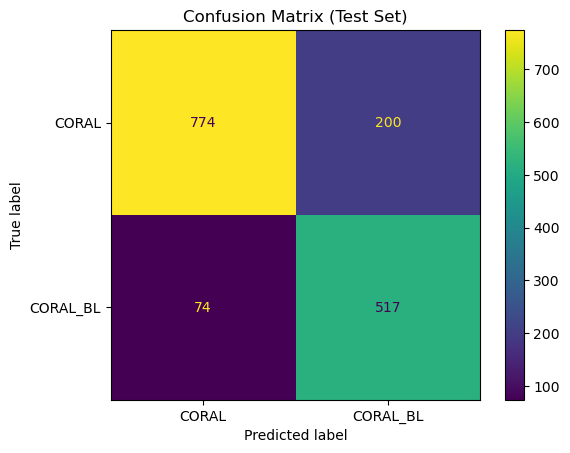

In [26]:
# Generate confusion matrix for test set

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

labels = ["CORAL", "CORAL_BL"]
y_pred_probs = model_small.predict(combined_input_test)
y_pred = (y_pred_probs > 0.5).astype("int32")
cm = confusion_matrix(labels_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cmd.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [27]:
# Generate classification report for test set

from sklearn.metrics import classification_report
labels = ["CORAL", "CORAL_BL"]
report = classification_report(labels_test, y_pred, target_names=labels)
print("Classification Report (Test Set) : \n")
print(report)

Classification Report (Test Set) : 

              precision    recall  f1-score   support

       CORAL       0.91      0.79      0.85       974
    CORAL_BL       0.72      0.87      0.79       591

    accuracy                           0.82      1565
   macro avg       0.82      0.83      0.82      1565
weighted avg       0.84      0.82      0.83      1565

